In [92]:
#Imports
from tslearn.clustering import TimeSeriesKMeans
import pandas as pd
import os
import tensorflow as tf
from keras import backend as K

from utils.modelgenerator import *
from utils.modelhandler import *
from utils.datahandler import *

#!pip install MiniSom
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler

#Get data 
cwd = os.path.normpath(os.getcwd())
df = pd.read_csv(cwd+'/data/df_with_final_features.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)
#df = df[['User5', 'temp', 'rhum']]
df.fillna(0, inplace=True)
df.head()

,User1,User10,User11,User12,User13,User14,User15,User16,User17,User18,...,User27_lag_24hrs,User28_lag_24hrs,User29_lag_24hrs,User30_lag_24hrs,User31_lag_24hrs,User32_lag_24hrs,User33_lag_24hrs,User34_lag_24hrs,User35_lag_24hrs,User36_lag_24hrs
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-08 00:00:00,0.200,0.099,0.312,0.152,1.227,0.162,0.089,1.079,0.366,0.063,...,0.040,0.100,0.522,0.058,0.211,0.066,0.627,0.844,0.413,0.117
2012-07-08 01:00:00,0.253,0.060,0.263,0.212,0.132,0.204,0.072,0.714,0.134,0.063,...,0.050,0.131,0.104,0.031,0.271,0.112,0.417,0.350,0.310,0.552
2012-07-08 02:00:00,0.441,0.028,0.257,0.218,0.144,0.193,0.067,0.706,0.127,0.061,...,0.051,0.106,0.163,0.022,0.280,0.121,0.324,0.313,0.285,0.055
2012-07-08 03:00:00,0.220,0.054,0.243,0.225,0.139,0.170,0.045,0.796,0.134,0.061,...,0.111,0.100,0.115,0.032,0.279,0.119,0.306,0.331,0.270,0.067
2012-07-08 04:00:00,0.635,0.060,0.245,0.188,1.157,0.146,0.064,0.755,0.154,0.063,...,0.083,0.094,0.148,0.067,0.184,0.120,0.287,0.275,0.273,0.033


In [78]:
columns_to_keep = []

for column_name in df.columns:
    if column_name.startswith('User') and column_name[4:].isdigit():
        user_number = int(column_name[4:])
        if 1 <= user_number <= 30:
            columns_to_keep.append(column_name)

filtered_df = df[columns_to_keep]
filtered_df.reset_index(inplace=True)
filtered_df

,Date,User1,User10,User11,User12,User13,User14,User15,User16,User17,...,User28,User29,User3,User30,User4,User5,User6,User7,User8,User9
0,2012-07-08 00:00:00,0.200,0.099,0.312,0.152,1.227,0.162,0.089,1.079,0.366,...,0.144,0.418,0.979,0.024,0.092,0.084,0.509,0.106,0.133,0.011
1,2012-07-08 01:00:00,0.253,0.060,0.263,0.212,0.132,0.204,0.072,0.714,0.134,...,0.125,0.065,0.049,0.060,0.090,0.091,0.489,0.067,0.076,0.011
2,2012-07-08 02:00:00,0.441,0.028,0.257,0.218,0.144,0.193,0.067,0.706,0.127,...,0.088,0.048,0.046,0.057,0.091,0.076,0.573,0.066,0.071,0.015
3,2012-07-08 03:00:00,0.220,0.054,0.243,0.225,0.139,0.170,0.045,0.796,0.134,...,0.100,0.049,0.053,0.050,0.098,0.079,0.363,0.084,0.073,0.011
4,2012-07-08 04:00:00,0.635,0.060,0.245,0.188,1.157,0.146,0.064,0.755,0.154,...,0.088,0.066,0.040,0.022,0.096,0.133,0.595,0.129,0.073,0.019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8587,2013-06-30 19:00:00,0.335,0.198,1.362,1.385,0.237,0.331,0.082,0.671,0.418,...,1.381,0.582,0.052,0.350,0.280,2.152,1.018,0.066,0.563,0.089
8588,2013-06-30 20:00:00,0.213,0.873,0.687,1.347,0.282,0.940,0.095,0.507,0.510,...,0.225,0.389,0.050,0.591,0.273,1.993,0.910,0.103,0.104,0.053
8589,2013-06-30 21:00:00,0.190,0.113,0.675,1.615,1.193,0.290,0.115,0.219,0.487,...,0.931,0.749,0.112,0.513,0.253,0.814,1.011,0.076,0.086,0.048
8590,2013-06-30 22:00:00,0.274,0.092,0.747,1.636,0.132,0.265,0.080,0.105,0.197,...,0.119,0.391,0.056,0.168,0.134,0.390,1.063,0.084,0.203,0.072


# K-manes Clustering

In [3]:
# Version 1 -------------------------- 4
N_CLUSTERS=4

model = TimeSeriesKMeans(n_clusters=N_CLUSTERS, metric="dtw", max_iter=40)
data_array = np.array(filtered_df.T.drop('Date').values)
model.fit(data_array)
y=model.predict(data_array)
x = filtered_df.Date
print("Clustering results: ", y)

c:\Users\rs1044\bwSyncShare\02Python Code\MoE-based-FL-for-secure-STLF\.venv\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 30 1-dimensional timeseries
  warnings.warn(


Clustering results:  [0 0 3 0 0 2 0 3 3 0 0 0 2 3 0 0 0 2 3 2 0 0 0 0 0 2 3 0 1 0]


In [4]:
np.savetxt('evaluations/federated_learning/clusters_KMeans4_dtw.csv', y, delimiter=",")

In [17]:
# Version 1 -------------------------- 6
N_CLUSTERS=6

model = TimeSeriesKMeans(n_clusters=N_CLUSTERS, metric="dtw", max_iter=40)
data_array = np.array(filtered_df.T.drop('Date').values)
model.fit(data_array)
y=model.predict(data_array)
x = filtered_df.Date
print("Clustering results: ", y)


c:\Users\rs1044\bwSyncShare\02Python Code\MoE-based-FL-for-secure-STLF\.venv\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 30 1-dimensional timeseries
  warnings.warn(


Clustering results:  [1 1 2 1 4 1 1 2 3 1 1 2 5 0 4 1 2 5 2 1 1 1 1 1 1 1 2 1 3 1]


In [19]:
np.savetxt('evaluations/federated_learning/clusters.csv', y, delimiter=",")
#y = np.loadtxt('evaluations/federated_learning/clusters.csv', delimiter=',').astype(int)
#print("Clustered clients: ", y)

In [5]:
# Version 1 -------------------------- 8
N_CLUSTERS=8

model = TimeSeriesKMeans(n_clusters=N_CLUSTERS, metric="dtw", max_iter=40)
data_array = np.array(filtered_df.T.drop('Date').values)
model.fit(data_array)
y=model.predict(data_array)
x = filtered_df.Date
print("Clustering results: ", y)

c:\Users\rs1044\bwSyncShare\02Python Code\MoE-based-FL-for-secure-STLF\.venv\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 30 1-dimensional timeseries
  warnings.warn(


Clustering results:  [5 2 0 2 0 0 2 4 3 2 2 0 1 4 0 2 0 1 7 0 2 0 2 2 2 2 4 2 6 2]


In [6]:
np.savetxt('evaluations/federated_learning/clusters_KMeans8_dtw.csv', y, delimiter=",")

In [3]:
# Version 2 -------------------------- K-menas 10 cluster
N_CLUSTERS=10

model = TimeSeriesKMeans(n_clusters=N_CLUSTERS, metric="dtw", max_iter=40)
data_array = np.array(filtered_df.T.drop('Date').values)
model.fit(data_array)
y=model.predict(data_array)
x = filtered_df.Date
print("Clustering results: ", y)

c:\Users\rs1044\bwSyncShare\02Python Code\MoE-based-FL-for-secure-STLF\.venv\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 30 1-dimensional timeseries
  warnings.warn(


Clustering results:  [9 2 0 2 0 0 2 0 5 2 2 0 8 3 7 2 0 1 6 0 2 0 2 2 2 2 0 2 4 2]


In [4]:
np.savetxt('evaluations/federated_learning/clusters_KMeans10_dtw.csv', y, delimiter=",")

In [79]:
# Version 2 -------------------------- K-menas 10 cluster
N_CLUSTERS=15

model = TimeSeriesKMeans(n_clusters=N_CLUSTERS, metric="dtw", max_iter=40)
data_array = np.array(filtered_df.T.drop('Date').values)
model.fit(data_array)
y=model.predict(data_array)
x = filtered_df.Date
print("Clustering results: ", y)

c:\Users\rs1044\bwSyncShare\02Python Code\MoE-based-FL-for-secure-STLF\.venv\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 30 1-dimensional timeseries
  warnings.warn(


Clustering results:  [10  4 13 14 12 10  7  9  2  4  7 10  3  8  5 10  0  1 11  0  7  4  7  4
  7 10 13  7  6  4]


In [80]:
np.savetxt('evaluations/federated_learning/clusters_KMeans15_dtw.csv', y, delimiter=",")

# Self-organized maps

c:\Users\rs1044\bwSyncShare\02Python Code\MoE-based-FL-for-secure-STLF\.venv\lib\site-packages\minisom.py:162: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


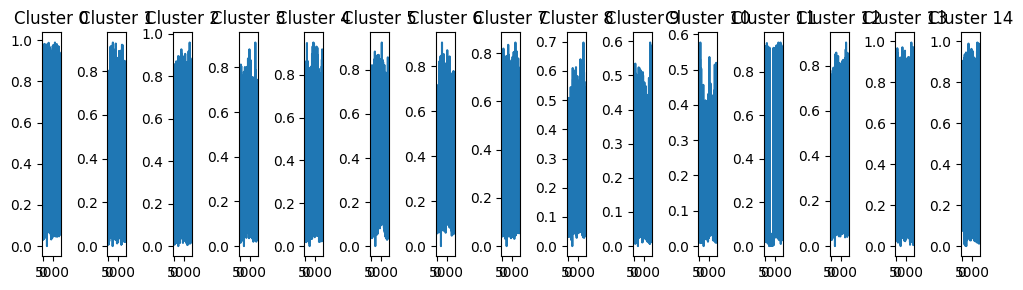

In [90]:
num_clusters = 15
#Scaling
# Extract the consumption data from the User columns
consumption_data = filtered_df[['User{}'.format(i) for i in range(1, 31)]].values
consumption_data = consumption_data.T
# Scale the data to [0, 1] range
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(consumption_data)

# Create the SOM with a 1D grid
som = MiniSom(1, num_clusters, input_len=8592 , sigma=1.0, learning_rate=0.5)

# Initialize and train the SOM
som.random_weights_init(scaled_data)
som.train_random(scaled_data, num_iteration=100)  # You can adjust the number of iterations

# Assign clusters to users
cluster_labels = []
for x in scaled_data:
    bmu = som.winner(x)
    cluster_labels.append(bmu[1])  # Extract the cluster label

cluster_centers = som.get_weights()

# Example: Visualize cluster centers
import matplotlib.pyplot as plt

som_shape = (1, num_clusters)

plt.figure(figsize=(10, 3))
for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        plt.subplot(som_shape[0], som_shape[1], i * som_shape[1] + j + 1)
        plt.plot(cluster_centers[i, j], label=f'Cluster {i * som_shape[1] + j}')
        plt.title(f'Cluster {i * som_shape[1] + j}')
plt.tight_layout()
plt.show()

In [91]:
np.savetxt(f'evaluations/federated_learning/clusters_SOM{num_clusters}.csv', cluster_labels, delimiter=",")
print(cluster_labels)


[7, 11, 10, 13, 8, 6, 10, 6, 10, 9, 6, 6, 9, 8, 10, 14, 5, 8, 10, 3, 0, 9, 2, 8, 4, 7, 1, 8, 8, 10]
